In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import pytorch_hyperlight as pth
import pytorch_lightning as pl
import torch
import torch.nn as nn
import transformers as ppb
from pytorch_hyperlight.tasks.classification import (
    AAutoClsHeadClassificationTaskWDAdamWWarmup,
)
from torch.utils.data import DataLoader, Dataset, Sampler, random_split

import torch.nn.functional as F
import random

In [2]:
warnings.filterwarnings("ignore")

In [3]:
EXPERIMENT_ID = 'bert_sst2_subset_finetuning'
FAST_DEV_RUN = False
SEED = 16

In [4]:
class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return math.ceil(len(self.subset) / self.batch_size)


def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0] * (max_len - len(value)) for value in values])

    return padded


def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem["tokenized"])
        labels.append(elem["label"])

    inputs = get_padded(inputs)  # padded inputs
    attention_mask = np.where(inputs != 0, 1, 0)

    return {
        "inputs": torch.tensor(inputs),
        "labels": torch.FloatTensor(labels),
        "attention_mask": torch.tensor(attention_mask),
    }


class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels, df_indices):
        self.labels = labels
        self.df_indices = df_indices
        # tokenized reviews
        self.tokenized = [tokenizer.encode(x, add_special_tokens=True) for x in reviews]

    def __getitem__(self, idx):
        return {
            "tokenized": self.tokenized[idx],
            "label": self.labels[idx],
            "df_index": self.df_indices[idx],
        }

    def __len__(self):
        return len(self.labels)

In [5]:
def configure_dataloaders(batch_size, n_workers=4):
    pl.seed_everything(SEED)
    df = pd.read_csv(
        "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
        delimiter="\t",
        header=None,
    )

    tokenizer = ppb.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    dataset = ReviewsDataset(
        df[0].to_list(), tokenizer, df[1].to_list(), df.index.to_list()
    )

    train_size, val_size = int(0.8 * len(dataset)), int(0.1 * len(dataset))
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, len(dataset) - train_size - val_size]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_sampler=ReviewsSampler(train_dataset, batch_size=batch_size),
        collate_fn=collate_fn,
        num_workers=n_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_sampler=ReviewsSampler(val_dataset, batch_size=batch_size),
        collate_fn=collate_fn,
        num_workers=n_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_sampler=ReviewsSampler(test_dataset, batch_size=batch_size),
        collate_fn=collate_fn,
        num_workers=n_workers,
        pin_memory=True,
    )
    loaders_dict = {
        "df": df,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
    }
    return loaders_dict

In [6]:
loaders_dict = configure_dataloaders(batch_size=3)
loaders_dict
batch = next(iter(loaders_dict["train_loader"]))

Global seed set to 16


In [7]:
batch

{'inputs': tensor([[  101, 27150,   102],
         [  101,  6659,   102],
         [  101, 19424,   102]]),
 'labels': tensor([1., 0., 0.]),
 'attention_mask': tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]])}

In [8]:
test_dataset = loaders_dict["test_dataset"]
orig_df = loaders_dict["df"]

In [9]:
def get_label(prob):
    if prob > 0.5:
        label = "positive"
    else:
        label = "negative"
    return label

In [10]:
def show_dataset(test_dataset, orig_df, n_samples, f_get_pred_prob=None):
    for _ in range(n_samples):
        ind = random.randrange(len(test_dataset))
        input_data_dict = test_dataset[ind]

        df_index = input_data_dict["df_index"]
        input_sentence = orig_df.iloc[df_index][0]
        if f_get_pred_prob is not None:
            pred_prob = f_get_pred_prob(input_data_dict)
            pred_label = get_label(pred_prob)
            prefix = f"Pred. label: {pred_label}\n"
        else:
            prefix = ""

        true_label = get_label(input_data_dict["label"])
        print(f"{prefix}True label: {true_label}\n\t [{input_sentence}]\n")

In [11]:
show_dataset(test_dataset, orig_df, 5)

True label: positive
	 [fudges fact and fancy with such confidence that we feel as if we 're seeing something purer than the real thing]

True label: positive
	 [lrb d rrb espite its familiar subject matter , ice age is consistently amusing and engrossing]

True label: negative
	 [adam sandler 's heart may be in the right place , but he needs to pull his head out of his butt]

True label: negative
	 [what jackson has done is proven that no amount of imagination , no creature , no fantasy story and no incredibly outlandish scenery]

True label: positive
	 [it is scott 's convincing portrayal of roger the sad cad that really gives the film its oomph]



In [12]:
N_CLASSES = 1
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

In [13]:
CONFIG = {
    "classifier_lr": 1e-3,  # Initial learning rate
    "rest_lr": 3e-5,  # Initial learning rate
    "warmup": 500,  # For LinearSchedulerWihtWarmup
    "gradient_clip_val": 0,
    "max_epochs": 6,  # the actual number can be less due to early stopping
    "batch_size": 32,
    "n_classes": N_CLASSES,
    "classifier_dropout": 0.2,
    "weight_decay": 0.01,
    "no_weight_decay_param_names": ["bias", "LayerNorm.weight"],
}

TUNE_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 6,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 7,  # for PTL Trainer
    "ptl_precision": 32,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

In [14]:
class BertClassifier(AAutoClsHeadClassificationTaskWDAdamWWarmup):
    def __init__(self, hparams):
        model = ppb.DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased"
        )
        criterion = nn.BCEWithLogitsLoss()
        super().__init__(hparams, model, criterion)

    def _forward_batch(self, batch):
        inputs = batch["inputs"]
        attention_mask = batch["attention_mask"]
        return self(inputs, attention_mask=attention_mask)["logits"].squeeze(1)

    @staticmethod
    def _get_target_from_batch(batch):
        return batch["labels"]

    def _get_classifier_module_name(self):
        return "classifier"

In [15]:
runner = pth.Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 16
Global seed set to 16
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification

Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

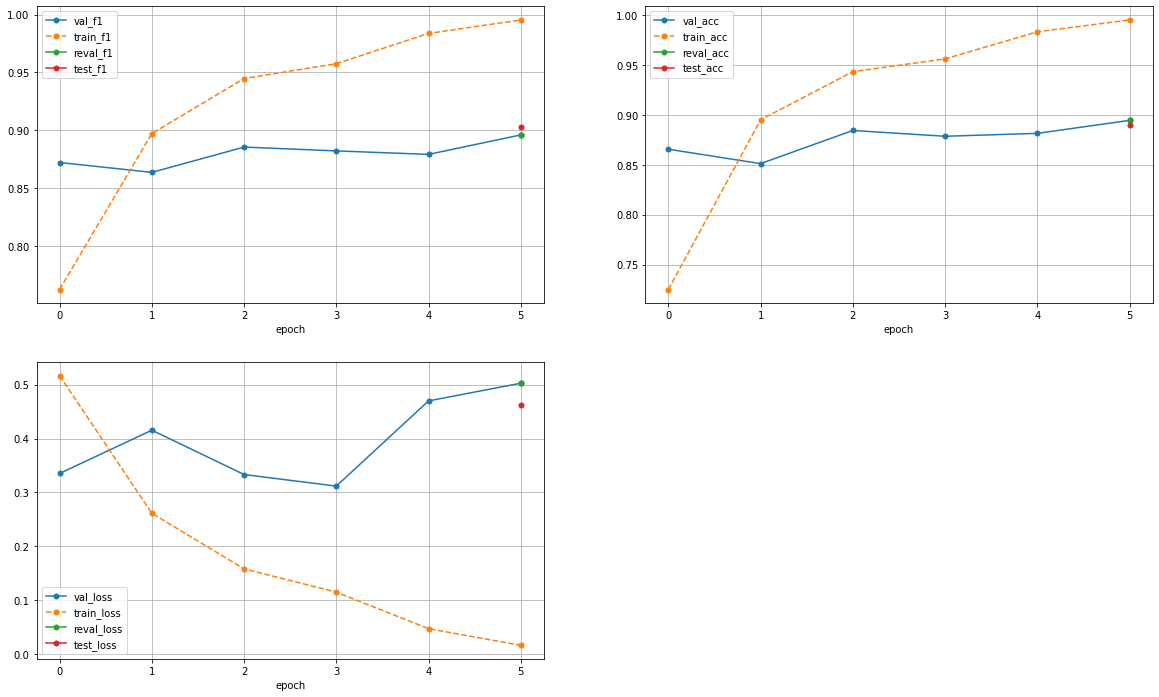

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [16]:
best_result = runner.run_single_trial(BertClassifier, CONFIG, TUNE_CONFIG)

In [17]:
runner.get_metrics()["run_x_last_metric_df"]

,val_f1,train_f1,val_acc,train_acc,val_loss,train_loss,reval_f1,reval_acc,reval_loss,test_f1,test_acc,test_loss,run
7,0.8962,0.9953,0.8945,0.9951,0.5028,0.0163,0.8962,0.8945,0.5028,0.9026,0.8902,0.463,single-trial-BertClassifier


In [18]:
lmodule = best_result["lmodule_best"].eval()

In [19]:
def get_pred_prob(input_data_dict):
    input_tensor = torch.tensor(
        input_data_dict["tokenized"], device=lmodule.device
    ).unsqueeze(0)
    with torch.no_grad():
        pred_prob = F.sigmoid(lmodule(input_tensor)["logits"]).item()
    return pred_prob

In [20]:
show_dataset(test_dataset, orig_df, 10, get_pred_prob)

Pred. label: positive
True label: positive
	 [fudges fact and fancy with such confidence that we feel as if we 're seeing something purer than the real thing]

Pred. label: positive
True label: positive
	 [lrb d rrb espite its familiar subject matter , ice age is consistently amusing and engrossing]

Pred. label: negative
True label: negative
	 [adam sandler 's heart may be in the right place , but he needs to pull his head out of his butt]

Pred. label: negative
True label: negative
	 [what jackson has done is proven that no amount of imagination , no creature , no fantasy story and no incredibly outlandish scenery]

Pred. label: positive
True label: positive
	 [it is scott 's convincing portrayal of roger the sad cad that really gives the film its oomph]

Pred. label: positive
True label: negative
	 [more successful at relating history than in creating an emotionally complex , dramatically satisfying heroine]

Pred. label: positive
True label: positive
	 [a treat for its depiction on